# Практические задания к лекции № 3

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других

In [1]:
import pandas as pd
import numpy as np

In [57]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate

In [3]:
import matplotlib.pyplot as plt

In [4]:
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("train_case2.csv", sep=';', index_col=0)
df.head(3).T

id,0,1,2
age,18393.0,20228.0,18857.0
gender,2.0,1.0,1.0
height,168.0,156.0,165.0
weight,62.0,85.0,64.0
ap_hi,110.0,140.0,130.0
ap_lo,80.0,90.0,70.0
cholesterol,1.0,3.0,3.0
gluc,1.0,1.0,1.0
smoke,0.0,0.0,0.0
alco,0.0,0.0,0.0


In [6]:
df['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

In [7]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

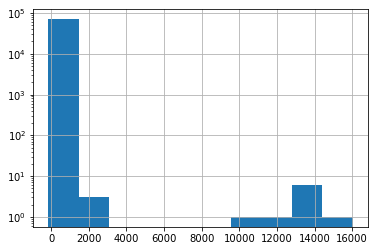

In [8]:
df.ap_hi.hist(log=True)

<AxesSubplot:>

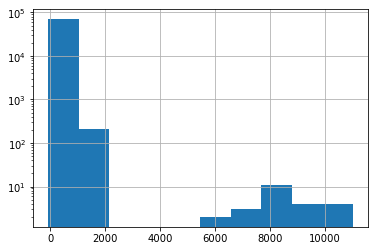

In [9]:
df.ap_lo.hist(log=True)

Приведём немного в порядок данные по давлению

In [10]:
for ap in ['ap_hi', 'ap_lo']:
    df.loc[df[ap] < 0, ap] = df[ap] * (-1)
    df.loc[(df[ap] > 300) & (df[ap] < 5000), ap] = df[ap] // 10
    df.loc[df[ap] >= 5000, ap] = df[ap] // 100
    df.loc[df[ap] == 1, ap] = df[ap] * 100
    df.loc[df[ap] < 20, ap] = df[ap] * 10
    
df.loc[df['ap_lo'] == 0, 'ap_lo'] = np.median(df['ap_lo'])

<AxesSubplot:>

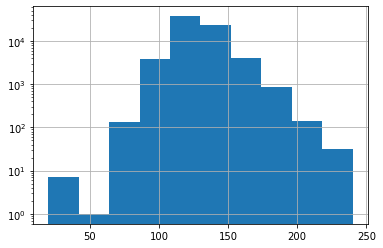

In [11]:
df.ap_hi.hist(log=True)

<AxesSubplot:>

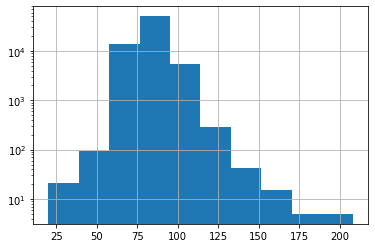

In [12]:
df.ap_lo.hist(log=True)

In [22]:
y = df['cardio']
X = df.drop('cardio', 1)

In [23]:
models = [xgb.XGBClassifier(random_state=28), 
         lgbm.LGBMClassifier(random_state=28),
         catb.CatBoostClassifier(silent=True, random_state=28)]

In [58]:
scores = []
for alg in models:
    scores.append(cross_validate(alg, X, y, cv=3, scoring=('precision', 'recall', 'roc_auc', 'f1'),
                         return_train_score=True))

[19:11:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:11:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:11:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [59]:
scores_mean = []
for alg in scores:
    lst = {}
    for key in alg.keys():
        if (str(key) == 'fit_time') or (str(key) == 'score_time'):
            continue
        else:
            lst[str(key)] = np.mean(alg[key])
    scores_mean.append(lst)

In [60]:
df = pd.DataFrame(scores_mean, ['XGB', 'LGBM', 'CatBoost']).T
df

,XGB,LGBM,CatBoost
test_precision,0.751790,0.756029,0.755652
train_precision,0.794296,0.772788,0.779870
test_recall,0.692444,0.695732,0.696103
train_recall,0.728208,0.709812,0.718788
test_roc_auc,0.796247,0.802262,0.801654
train_roc_auc,0.850612,0.827131,0.835380
test_f1,0.720887,0.724609,0.724647
train_f1,0.759803,0.739942,0.748075


Разница между алгоритмами незначительна, но всё же LGBM и CatBoost справились лучще xgboostа.

5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

1 модель:

In [98]:
TP = 90
FP = 10
TN = 99890
FN = 10

roc_auc_curve

In [99]:
TPR_1 = TP/(TP + FN)
FPR_1 = FP/(FP + TN)

precision_recall_curve

In [100]:
precision_1 = TP/(TP + FP)
recall_1 = TP/(TP + FN)

2 модель:

In [101]:
TP = 90
FP = 910
TN = 98990
FN = 10

In [102]:
TPR_2 = TP/(TP + FN)
FPR_2 = FP/(FP + TN)

precision_recall_curve

In [103]:
precision_2 = TP/(TP + FP)
recall_2 = TP/(TP + FN)

In [104]:
pd.DataFrame({'alg_1': [TPR_1, FPR_1, precision_1, recall_1], 'alg_2': [TPR_2, FPR_2, precision_2, recall_2]}, 
             ['TPR', 'FPR', 'precision', 'recall'])

,alg_1,alg_2
TPR,0.9000,0.900000
FPR,0.0001,0.009109
precision,0.9000,0.090000
recall,0.9000,0.900000


Второй алгоритм хуже из-за того, что просела точность без малого в 10 раз. По roc_auc_curve это было бы не понятно. Таким образом, precision_recall_curve больше подходит в случае сильного дисбаланса классов